In [1]:
# -*- coding: utf-8 -*-
import torch
import copy
from core.loader import Loader
from models.model_wrapper import ModelWrapper
from core.loader import Loader
import numpy as np

from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


2025-04-27 23:42:00.534470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-27 23:42:00.534505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 23:42:00.565136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 23:42:00.635216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-27 23:42:01.637572: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2025-04-27 23:42:03.331606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 23:42:03.460246: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 23:42:03.463137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Combined approach

In [2]:
benign_dataset_filenames = [
    'parkets/benign/benign_2312_anonymized_HTML.parquet', 
    'parkets/benign/umbrella_benign_FINISHED_HTML.parquet'
        
]
malicious_dataset_filenames = [
    'parkets/phishing_2406_strict_HTML.parquet'
]

# CONFIGURATION

benign_label = "benign"
malicious_label = "phishing"

class_map = {benign_label: 0, malicious_label: 1}
# print labels from malicious datasets

loader = Loader(benign_dataset_filenames, malicious_dataset_filenames, benign_label=benign_label, malicious_label=malicious_label, subsample=1.0)
df = loader.load()

# Stages split

In [3]:
from core.segmenter import Segmenter

# Define the aggregates that needs to be created

aggregates = [
    ["lex_"],
    ["lex_", "dns_", "ip_", "geo_"],
    ["lex_", "dns_", "ip_", "tls_", "geo_", "rdap_"],
]

segmenter = Segmenter(df)
segmenter.create_base_subsets() # create base subsets
segmenter.create_aggregated_subsets(aggregates)
subset_dfs = segmenter.get_aggregated_subsets()

/home/poli/Desktop/git/deep_domain_detection/src/core/segmenter.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["label"] = self.df["label"].copy()
/home/poli/Desktop/git/deep_domain_detection/src/core/segmenter.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["label"] = self.df["label"].copy()
/home/poli/Desktop/git/deep_domain_detection/src/core/segmenter.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [4]:
# iterate over each subset and print its shape
for subset_name, subset_df in subset_dfs.items():
    print(f"Subset: {subset_name}, Shape: {subset_df.shape}")

Subset: lex_agg, Shape: (980749, 63)
Subset: lex_+dns_+ip_+geo_agg, Shape: (980749, 129)
Subset: lex_+dns_+ip_+tls_+geo_+rdap_agg, Shape: (980749, 177)


# Train loop 

In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

ARCH_NAME = "svm"
VERSION = "v1.1"
LR = 0.0023


# Define early stopping criteria

wrapper = ModelWrapper()

def svm_convert(df):
    df = df.fillna(0)
    df = df.replace({True: 1, False: 0})
    return np.array(df)

for prefix, subset_df in subset_dfs.items():
    
    
    labels = subset_df['label'].apply(lambda x: class_map[x]) # y vector
    features = subset_df.drop('label', axis=1).copy() # X matrix
    
    labels = svm_convert(labels)
    features = loader.scale(features)
    features = svm_convert(features)
    
    x_train, x_test, y_train, y_test = train_test_split(
        features,
        labels,
        test_size=0.2,
        random_state=42,
        shuffle=True, 
        stratify=labels
    )

  

    # params found by gradient grid search 
    params = {
    "C": 59,
    "gamma": 0.1,
    "kernel": "rbf",
    "random_state": 42,
    "class_weight": "balanced"
    }
    model = SVC(**params, verbose=True)
    model.fit(x_train, y_train)
    
    try:
        # print the model's parameters
        print("Model parameters:")
        for param, value in model.get_params().items():
            print(f"{param}: {value}")
            
        y_pred = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        # print classification report
        from sklearn.metrics import classification_report
        print("Classification report on test set:")
        print(classification_report(y_test, y_pred, target_names=class_map.keys()))
        print("Classification report on train set:")
        print(classification_report(y_train, y_pred_train, target_names=class_map.keys()))
    except Exception as e:
        print(f"Error during model evaluation: {e}")
        print("But we can go on....")


    wrapper.save(model, arch_name=ARCH_NAME, label=malicious_label, prefix=f"{prefix}", version=VERSION)



ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

# SVM model, params defined from tuning process

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import numpy as np

model_wrapper = ModelWrapper(model_dir="models")

svm_x_train = copy.deepcopy(X_train)
svm_x_test = copy.deepcopy(X_test)
svm_y_train = copy.deepcopy(y_train)
svm_y_test = copy.deepcopy(y_test)


# Subsample the training data
svm_x_train, _, svm_y_train, _ = train_test_split(
    svm_x_train, svm_y_train, test_size=0.2, random_state=42, shuffle=True, stratify=svm_y_train
)

print(f"After Subsampling - svm_x_train: {len(svm_x_train)}, svm_y_train: {len(svm_y_train)}")

# Fill NaNs with zero (to ensure there are no NaNs after encoding)
svm_x_train.fillna(0, inplace=True)
svm_x_test.fillna(0, inplace=True)
svm_y_train.fillna(0, inplace=True)
svm_y_test.fillna(0, inplace=True)

# Convert to numpy arrays
svm_x_train = np.array(svm_x_train)
svm_x_test = np.array(svm_x_test)
svm_y_train = np.array(svm_y_train)
svm_y_test = np.array(svm_y_test)

# Convert logical values False and True to 0 and 1
svm_x_train = np.where(svm_x_train == False, 0, np.where(svm_x_train == True, 1, svm_x_train))
svm_x_test = np.where(svm_x_test == False, 0, np.where(svm_x_test == True, 1, svm_x_test))

# Scaling
scaler = MinMaxScaler()
svm_x_train = scaler.fit_transform(svm_x_train)
svm_x_test = scaler.transform(svm_x_test)

# Define SVM model parameters and train
params = {
    "C": 59,
    "gamma": 0.1,
    "kernel": "rbf",
    "random_state": 42,
    "class_weight": "balanced"
}
model = SVC(**params, verbose=True)
model.fit(svm_x_train, svm_y_train)


model_wrapper.save(model, arch_name="SVM", label="phishing", prefix="lex_+dns_+ip_+tls_+geo_+rdap__agg", version="v1.0")



After Subsampling - svm_x_train: 125536, svm_y_train: 125536
[LibSVM]................................................................................................................*........................................................*
optimization finished, #iter = 168173
obj = -215728.903167, rho = -4.899930
nSV = 9280, nBSV = 3964
Total nSV = 9280
✅ Saved model to models/SVM_stage_3_phishing_v1.0.pkl


True Negatives (TN): 32212
False Positives (FP): 455
False Negatives (FN): 330
True Positives (TP): 6233

False Positive Rate (FPR): 0.013928429301741818
True Positive Rate (TPR): 0.9497181167149169 (also known as Recall)

F1 Score: 0.9408

Classification Report:
              precision    recall  f1-score   support

           0     0.9899    0.9861    0.9880     32667
           1     0.9320    0.9497    0.9408      6563

    accuracy                         0.9800     39230
   macro avg     0.9609    0.9679    0.9644     39230
weighted avg     0.9802    0.9800    0.9801     39230



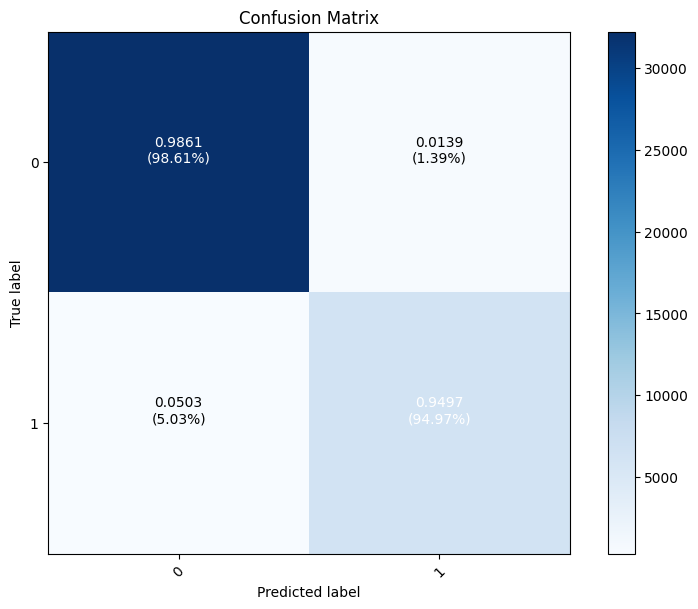

In [9]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix


class ModelValidator:
    """
    A class for validating machine learning models with various metrics.

    Attributes:
        model (estimator): The machine learning model to be validated.
        X_test (array-like): The test dataset features.
        y_test (array-like): The true labels corresponding to X_test.
    """

    def __init__(self, model, X_test, y_test):
        """
        The constructor for ModelValidator class.

        Parameters:
           model (estimator): The trained machine learning model.
           X_test (array-like): Features from the test dataset.
           y_test (array-like): True labels for the test dataset.
        """
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def evaluate_performance(self):
        """
        Evaluates and prints the model's performance metrics.
        """
        y_pred = self.model.predict(self.X_test)
        f1 = f1_score(self.y_test, y_pred)
        conf_matrix = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()

        # Calculating False Positive Rate (FPR) and True Positive Rate (TPR)
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0

        # Displaying basic metrics
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"True Positives (TP): {tp}\n")
        print(f"False Positive Rate (FPR): {fpr}")
        print(f"True Positive Rate (TPR): {tpr} (also known as Recall)\n")
        print(f"F1 Score: {f1:.4f}\n")

        # Display classification report
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred, digits=4))

        # Plotting the confusion matrix
        self.plot_confusion_matrix(y_pred)

    def plot_confusion_matrix(self, y_pred):
        """
        Plots the confusion matrix of the model's predictions with enhanced visual detail.

        Parameters:
           y_pred (array-like): Predicted labels for the test dataset.
        """
        cm = confusion_matrix(self.y_test, y_pred, labels=self.model.classes_)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(self.model.classes_))
        plt.xticks(tick_marks, self.model.classes_, rotation=45)
        plt.yticks(tick_marks, self.model.classes_)

        # Normalize the confusion matrix.
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Annotating the confusion matrix with text
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, f"{cm[i, j]:.4f}\n({cm[i, j]*100:.2f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

# Example usage
validator = ModelValidator(model, svm_x_test, svm_y_test)
validator.evaluate_performance()

In [3]:
from models.model_wrapper import ModelWrapper
from core.loader import Loader
import numpy as np


benign_label = "benign"
malicious_label = "phishing"

class_map = {benign_label: 0, malicious_label: 1}
# print labels from malicious datasets
malicious_dataset_filenames = [
    'parkets/2405_clftest_phishing_filtered_HTML.parquet'
]

benign_dataset_filenames = [
    'parkets/2405_clftest_benign_filtered_HTML.parquet'
]

loader = Loader(benign_dataset_filenames,  malicious_dataset_filenames, benign_label=benign_label, malicious_label=malicious_label, subsample=1.0)


df = loader.load()

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

features = loader.scale(features)
features.fillna(0, inplace=True)
features = np.array(features)
features = np.where(features == False, 0, np.where(features == True, 1, features))

# features = loader.scale(features)

# clasify all the features
model_wrapper = ModelWrapper(model_dir="models")
# load the model 
model = model_wrapper.load(arch_name="SVM", label="phishing", prefix="lex_+dns_+ip_+tls_+geo_+rdap__agg", version="v1.0")

# iterate over features and labels

for i in range(len(features)):
    # get the feature
    feature = features[i]
    # get the label
    label = labels[i]
    # predict the label
    prediction = model.predict([feature])
    # print the feature, label and prediction
    print(f"Label: {label}, Prediction: {prediction}")
    input( )








📦 Loading model from models/SVM_stage_3_phishing_v1.0.pkl
Label: 0    0
0    1
Name: label, dtype: int64, Prediction: [0]
Label: 1    0
1    1
Name: label, dtype: int64, Prediction: [0]
Label: 2    0
2    1
Name: label, dtype: int64, Prediction: [0]
Label: 3    0
3    1
Name: label, dtype: int64, Prediction: [0]
Label: 4    0
4    1
Name: label, dtype: int64, Prediction: [0]
Label: 5    0
5    1
Name: label, dtype: int64, Prediction: [0]
Label: 6    0
6    1
Name: label, dtype: int64, Prediction: [0]
Label: 7    0
7    1
Name: label, dtype: int64, Prediction: [0]
Label: 8    0
8    1
Name: label, dtype: int64, Prediction: [0]
Label: 9    0
9    1
Name: label, dtype: int64, Prediction: [0]
Label: 10    0
10    1
Name: label, dtype: int64, Prediction: [0]
Label: 11    0
11    1
Name: label, dtype: int64, Prediction: [0]
Label: 12    0
12    1
Name: label, dtype: int64, Prediction: [0]
Label: 13    0
13    1
Name: label, dtype: int64, Prediction: [0]
Label: 14    0
14    1
Name: label, dt

KeyboardInterrupt: Interrupted by user